# PyTorch を利用した実装（畳み込みニューラルネットワーク）

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/hseiyama/DeepLearning/blob/main/pytorch_basic_02_cnn.ipynb)

In [40]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### パラメータの定義

In [41]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### MNIST データセット

In [42]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### データローダー

In [43]:
# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("X.shape [N, C, H, W]:", X.shape)
    print("y.shape:", y.shape, y.dtype)
    break

X.shape [N, C, H, W]: torch.Size([100, 1, 28, 28])
y.shape: torch.Size([100]) torch.int64


#### 【オプション】入力データの確認

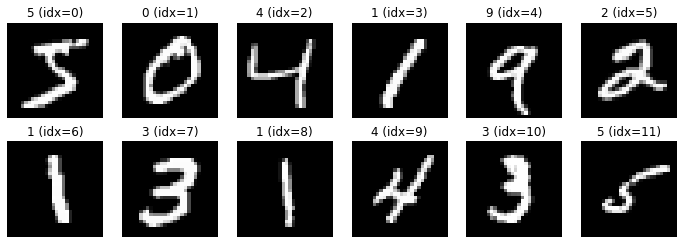

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5])


In [44]:
for X, y in train_dataloader:
    x_train = X
    t_train = y
    break

# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(y[:rows * cols])

### ニューラルネットワークの定義

In [48]:
# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            # 畳み込み層（入力チャンネル数、フィルタ数、フィルタサイズ、ストライド、パディング）
            nn.Conv2d(1, 30, kernel_size=5, stride=1, padding=0),  # 100x1x28x28 -> 100x30x24x24
            nn.ReLU(),
            # プーリング層（領域のサイズ、ストライド、パディング）
            nn.MaxPool2d(2, stride=2, padding=0))  # 100x30x24x24 -> 100x30x12x12
        self.layer2 = nn.Sequential(
            nn.Flatten(),  # 100x30x12x12 -> 100x(30*12*12) に変換
            nn.Linear(30*12*12, 100),  # 全結合層 100x(30*12*12) -> 100x100
            nn.ReLU())
        self.layer3 = nn.Linear(100, 10)  # 全結合層 100x100-> 100x10

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

### ニューラルネットワークのインスタンス化

In [49]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4320, out_features=100, bias=True)
    (2): ReLU()
  )
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)


### 損失関数と最適化手法を定義

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 訓練のプロセス

In [58]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 訓練モード
    loss_list = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #y = torch.eye(10)[y]  # index -> one-hot 形式に変換
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        print(f'\rbatch({batch}) loss = {loss_list[-1]}', end='')
    
    return loss_list

### 評価のプロセス

In [52]:
def test(dataloader, model):
    model.eval()  # 評価モード
    correct = 0
    size = len(dataloader.dataset)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    
    return correct

### ミニバッチの学習

In [59]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

for t in range(epoch_num):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_list += train_loss
    print(f'\repoch({t + 1}) loss = {train_loss_list[-1]}')
    train_acc = test(train_dataloader, model)
    test_acc = test(test_dataloader, model)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'epoch({t + 1}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) loss = 0.221671804785728454537
epoch(1) accuracy(train, test) = (0.9870333333333333, 0.9825)
epoch(2) loss = 0.213485762476921080841
epoch(2) accuracy(train, test) = (0.9887, 0.9842)
epoch(3) loss = 0.2078732848167419494513
epoch(3) accuracy(train, test) = (0.9903333333333333, 0.9846)
epoch(4) loss = 0.2067513614892959696883
epoch(4) accuracy(train, test) = (0.9914333333333334, 0.985)
epoch(5) loss = 0.2061943560838699393897
epoch(5) accuracy(train, test) = (0.9926166666666667, 0.9859)
epoch(6) loss = 0.2069190144538879494674
epoch(6) accuracy(train, test) = (0.99385, 0.9861)
epoch(7) loss = 0.2049100100994111158698
epoch(7) accuracy(train, test) = (0.9947833333333334, 0.9859)
epoch(8) loss = 0.2031425684690475555742
epoch(8) accuracy(train, test) = (0.9953, 0.9866)
epoch(9) loss = 0.2014852166175842323865
epoch(9) accuracy(train, test) = (0.9959666666666667, 0.987)
epoch(10) loss = 0.196452081203460770875
epoch(10) accuracy(train, test) = (0.9963666666666666, 0.9872)
epoch(11

### 損失関数の推移

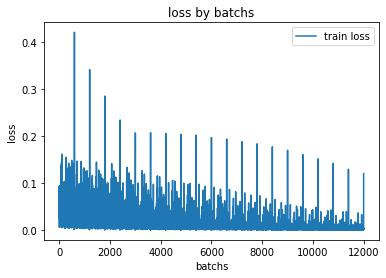

In [60]:
# グラフの描画
x = torch.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

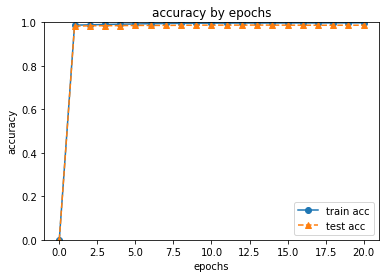

In [61]:
# グラフの描画
x = torch.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [62]:
x_test = None
t_test = None
test_predict = None

# テストの実行
model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        x_test = torch.cat((x_test,X),0) if x_test is not None else X
        t_test = torch.cat((t_test,y),0) if t_test is not None else y
        test_predict = torch.cat((test_predict,pred),0) if test_predict is not None else pred

print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

torch.Size([10000, 10])
index = 0
tensor([ -5.9851,   0.8014,   1.8033,   5.5341,  -2.1777,  -3.0708, -16.9398,
         19.4774,  -1.4151,   4.2242])
tensor(7)
index = 1
tensor([  6.6999,  10.2576,  26.5272,   0.3249, -10.3033, -10.8523,   4.4987,
         -4.0487,  -0.7645, -14.3225])
tensor(2)
index = 2
tensor([-2.5390, 15.7673,  1.5485, -8.5145,  3.9107, -6.3419, -1.3488,  4.0600,
         2.1464, -5.6719])
tensor(1)


#### 【オプション】エラー結果の確認

error rate = 1.3[%] (num = 130/10000)


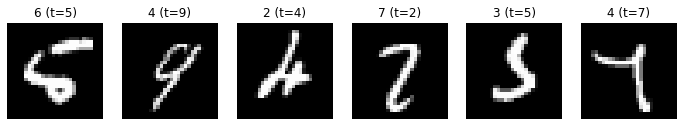

tensor([[ -3.4435, -14.7457, -11.6732,  -6.5811,   9.1316,  14.0470,  14.3000,
          -8.9473,   6.5476,   3.7726],
        [ -5.0001,  -0.9514,  -6.5219,  -5.1799,  12.8959,  -8.1344,  -4.4809,
           1.0753,   2.9308,  12.6095],
        [ -0.8428,   7.5765,  16.9542,  -9.4439,  13.4829,  -4.6744,  10.5672,
          -3.9334,  -0.7347, -21.5871],
        [ -1.2426,   4.0860,  14.2027,   8.3265, -11.1431, -13.5044, -18.9064,
          16.0630,   5.9985,   1.0939],
        [ -9.0020,   1.4450,  -6.0488,  11.5389,   0.7922,  11.3184,   4.4238,
          -9.8821,  -0.0609,  -4.7533],
        [ -6.4017,   6.6354,  -2.4431,   2.5882,  11.9317, -10.8380, -16.0100,
          11.8930,   3.0458,   6.0998]])


In [63]:
# エラー結果の要素を抽出
index_error = torch.argmax(test_predict, axis=1) != t_test
error_list = torch.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]',
      f'(num = {len(error_list)}/{len(test_predict)})')

offset = 0
# 画像を表示
figure = plt.figure(figsize=(12, 2))
rows, cols = 1, 6
for i in range(rows * cols):
    index = error_list[offset + i]
    img, label_t, label_y = x_test[index], t_test[index], test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(test_predict[error_list[offset:offset + rows * cols]])